## Description:

    Use DeSeq2 to identify differential abundance over time with just rhizosphere responders 
    Remove outlier points from ordination
   


# Setting variables

In [8]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan", "RColorBrewer")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.1’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’


In [4]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


In [5]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [6]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [12]:
%%R -i workDir

RhizEnrichedFile = file.path(workDir, 'BarevsHybrid.csv')

# log2 fold change analysis results file
df.r.l2fc = read.delim(RhizEnrichedFile, sep=',')
df.r.l2fc %>% head(n=3)

    baseMean log2FoldChange     lfcSE        stat    pvalue padj    Rank1
1  6.8726577      0.1300310 0.6832738  0.00000000 1.0000000    1 Bacteria
2  0.6131857      0.1269938 0.6180803  0.00000000 1.0000000    1 Bacteria
3 23.9158212     -1.0456672 0.5212742 -0.08760687 0.9301891    1 Bacteria
             Rank2                 Rank3          Rank4            Rank5
1 __Proteobacteria __Deltaproteobacteria __Myxococcales __Nannocystineae
2 __Proteobacteria __Deltaproteobacteria __Myxococcales __Nannocystineae
3 __Proteobacteria __Deltaproteobacteria __Myxococcales __Nannocystineae
            Rank6        Rank7                              Rank8      OTU
1 __Haliangiaceae __Haliangium             __uncultured_bacterium  OTU.871
2 __Haliangiaceae __Haliangium                               <NA> OTU.9547
3 __Haliangiaceae __Haliangium __uncultured_delta_proteobacterium  OTU.523
  TimePoint   Plant p.adj
1        T0 P1151HR     1
2        T0 P1151HR     1
3        T0 P1151HR     1


In [20]:
%%R
Responders = df.r.l2fc %>%
    filter(p.adj < 0.05) %>%
    .$OTU %>%
    unique %>% as.vector()
length(Responders)

[1] 299


In [22]:
%%R


#remove BARE soil controls and untreated seeds
physeq.plant = subset_samples(physeq.Full, Genotype != "BARE" & SeedTreatment == "Treated")

#prune to just responders
physeq.plant = prune_taxa(Responders, physeq.plant)

# Remove ordination outliers, see Ordination notebook
#physeq.plant = subset_samples(physeq.plant, !X.sampleID %in% c("ERA-T2_1-4c_85", "ERA-T2_4-4d_85"))


# Set rep as a factor
sample_data(physeq.plant)$Rep = factor(sample_data(physeq.plant)$Rep)   
sample_data(physeq.plant)$ERA = factor(sample_data(physeq.plant)$ERA)  


physeq.plant


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 299 taxa and 195 samples ]
sample_data() Sample Data:       [ 195 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 299 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 299 tips and 298 internal nodes ]


# l2f between ERAs at T2

In [23]:
%%R
physeq.plant.t2 = subset_samples(physeq.plant, TimePoint == "T2")
sample_data(physeq.plant.t2)$Plant = relevel(sample_data(physeq.plant.t2)$ERA, "1" )
sample_data(physeq.plant.t2)$Fert = as.factor(sample_data(physeq.plant.t2)$Fert)
sample_data(physeq.plant.t2)$Rep = as.factor(sample_data(physeq.plant.t2)$Rep)

In [24]:
%%R

diagdds = phyloseq_to_deseq2(physeq.plant.t2, ~ Rep + ERA)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rint

In [25]:
%%R
resultsNames(diagdds)

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "ERA1"     
[7] "ERA2"      "ERA3"     


In [27]:
%%R
# save taxa table
t.df = tax_table(physeq.plant.t2) %>% 
    as.data.frame() %>% 
    mutate(OTU = row.names(.)) 

In [30]:
%%R
r2_1 = results(diagdds, contrast=c("ERA", "2", "1"), independentFiltering = TRUE, parallel = TRUE, alpha = 0.05)

    df_era.2_1 = r2_1 %>% 
        as.data.frame %>% 
        mutate(TimePoint = "T2",
               Comparison = "ERA2_ERA1",
               OTU = rownames(.))

r3_1 = results(diagdds, contrast=c("ERA", "3", "1"), independentFiltering = TRUE, parallel = TRUE, alpha = 0.05)
    df_era.3_1 = r3_1 %>% 
    as.data.frame %>% 
    mutate(TimePoint = "T2",
           Comparison = "ERA3_ERA1",
           OTU = rownames(.))

r3_2 = results(diagdds, contrast=c("ERA", "3", "2"), independentFiltering = TRUE, parallel = TRUE, alpha = 0.05)
    df_era.3_2 = r3_2 %>% 
    as.data.frame %>% 
    mutate(TimePoint = "T2",
           Comparison = "ERA3_ERA2",
           OTU = rownames(.))

In [31]:
%%R
r2_1 %>% summary() %>% print()
r3_1 %>% summary() %>% print()
r3_2 %>% summary() %>% print()


out of 299 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 4, 1.3% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 6, 2% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL

out of 299 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 1, 0.33% 
LFC < 0 (down)   : 1, 0.33% 
outliers [1]     : 6, 2% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL

out of 299 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 3, 1% 
outliers [1]     : 6, 2% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


In [32]:
%%R
DF_ERA = bind_rows(df_era.2_1,df_era.3_1, df_era.3_2)

DF_ERA = left_join(DF_ERA, t.df, by = "OTU")

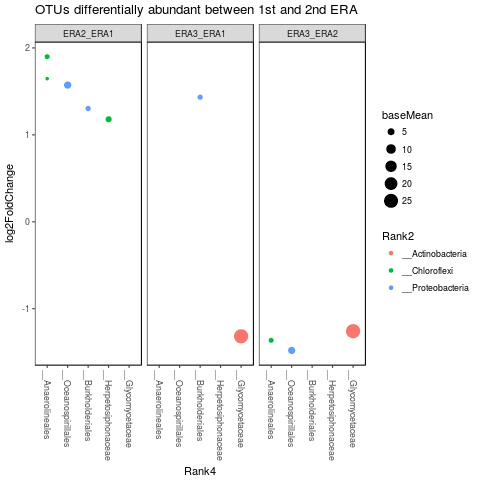

In [33]:
%%R
sigtab = DF_ERA %>% filter(padj < 0.1)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
  theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs differentially abundant between 1st and 2nd ERA")  +
   theme(legend.position="right") +
    facet_wrap(~Comparison)
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

# l2f between hybrids at T2

In [34]:
%%R
physeq.plant.t2 = subset_samples(physeq.plant, TimePoint == "T2")
sample_data(physeq.plant.t2)$Plant = relevel(sample_data(physeq.plant.t2)$Plant, "322" )
sample_data(physeq.plant.t2)$Fert = as.factor(sample_data(physeq.plant.t2)$Fert)
sample_data(physeq.plant.t2)$Rep = as.factor(sample_data(physeq.plant.t2)$Rep)

In [35]:
%%R

diagdds = phyloseq_to_deseq2(physeq.plant.t2, ~ Rep  + Plant)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

In [36]:
%%R
resultsNames(diagdds)

 [1] "Intercept"    "Rep1"         "Rep2"         "Rep3"         "Rep4"        
 [6] "Plant322"     "Plant330"     "Plant339"     "Plant3394"    "Plant3475"   
[11] "Plant34M95"   "Plant34N42"   "Plant3517"    "Plant354"     "Plant3541"   
[16] "Plant3618"    "PlantP1151HR"


In [37]:
%%R
#Function for gathering results

get_res = function(diagdds, plant) {
    r = results(diagdds, contrast=c("Plant", plant, "322"), independentFiltering = TRUE, parallel = TRUE)
    #r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    df = as.data.frame(r[, c("baseMean", "log2FoldChange", "lfcSE", "pvalue", "padj")])
    df$OTU = rownames(df)
    df$Plant = plant
    
    return(df)
}

In [40]:
%%R
Plants = sample_data(physeq.plant.t2)$Plant %>% levels %>% .[2:12] 
Plants

 [1] "330"     "339"     "3394"    "3475"    "34M95"   "34N42"   "3517"   
 [8] "354"     "3541"    "3618"    "P1151HR"


In [41]:
%%R
df_plant = NULL
df_plant = data.frame()
for (i in Plants) {
    plant = i
    DF = get_res(diagdds, plant)
    df_plant = rbind(df_plant, DF)
}
df_plant$TimePoint = "T2"
df_plant.t2 = df_plant

t.df = tax_table(physeq.plant.t2) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

df_plant.t2 = left_join(df_plant.t2, t.df, by = "OTU")

In [42]:
%%R
#df_plant.t1$p.adj = p.adjust(df_plant.t1$pvalue, "BH")
head(df_plant.t2) %>% print
tail(df_plant.t2) %>% print



   baseMean log2FoldChange     lfcSE     pvalue padj      OTU Plant TimePoint
1 7.1939790     1.14552013 0.6869282 0.09539555    1 OTU.1116   330        T2
2 1.7943835    -0.86358905 0.8196155 0.29204255    1 OTU.1968   330        T2
3 1.8892507     0.65436413 0.8213441 0.42562579    1 OTU.1848   330        T2
4 0.3682432     0.06018633 0.3563637 0.86588301    1 OTU.2441   330        T2
5 0.9943343    -0.34617818 0.8190451 0.67254285    1 OTU.1753   330        T2
6 0.8322817    -0.67482916 0.7955205 0.39627856    1 OTU.2260   330        T2
     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales

### Plot at T2

In [46]:
%%R
df.sig

    baseMean log2FoldChange     lfcSE       pvalue        padj       OTU Plant
1   3.259665       2.485206 0.6849168 2.850963e-04 0.042621897 OTU.11869  3394
2   2.779017      -2.993426 0.8197322 2.604983e-04 0.042621897   OTU.964  3394
3  36.823585       2.543713 0.6062488 2.718817e-05 0.008129263  OTU.5502  3475
4  17.527808       1.653793 0.5325123 1.898661e-03 0.047846254   OTU.313  3517
5   7.108187       3.059627 0.7512313 4.644810e-05 0.003901641   OTU.314  3517
6   7.712905       3.141648 0.7562463 3.263345e-05 0.003901641  OTU.4607  3517
7   5.421817       2.612445 0.7382872 4.023749e-04 0.016899746  OTU.1005  3517
8  23.714541       1.513415 0.4619477 1.052291e-03 0.033147159   OTU.183  3517
9  21.065424       2.012531 0.6354890 1.540725e-03 0.043140314   OTU.226  3517
10 12.474907       2.684762 0.7395043 2.828855e-04 0.014257430  OTU.3175  3517
11  5.205573       2.789431 0.7117597 8.889418e-05 0.005600333   OTU.923  3517
12  2.779017      -2.819269 0.8184717 5.720034e-04 0

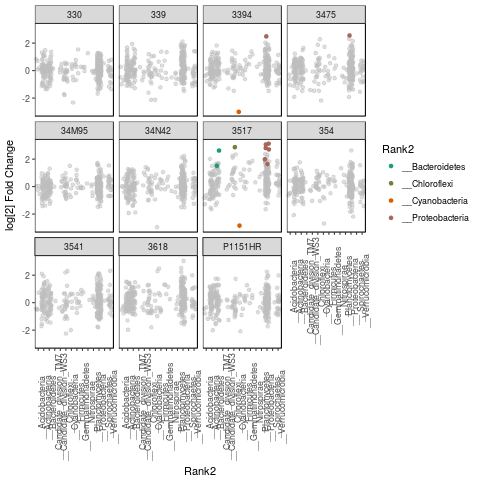

In [48]:
%%R
#df.adj = df_plant.t1[!is.na(df_plant.t1$padj),]

df.sig = df_plant.t2 %>% filter(padj < 0.05)
df.ns = df_plant.t2 %>% filter(padj >= 0.05)

colourCount = length(unique(df_plant.t2$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(df_plant.t2)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange), color = "Grey", alpha = 0.5, position = "jitter") +
    scale_shape_identity() +
       geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2),position = "jitter") +
               #geom_hline(y_intercept = .4) +
    facet_wrap(~Plant)+
    theme_pub() +
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))
p

### Compare OTUs identified in just the responder set vs entire set

In [67]:
%%R
l2f.h.a = read.csv("/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t2.csv")
dim(l2f.h.a)

[1] 40 17


In [68]:
%%R
#OTUs in both
semi_join(l2f.h.a, df.sig, by = "OTU" )

    X  baseMean log2FoldChange     lfcSE       pvalue        padj      OTU
1  27 17.053101       1.927532 0.4524241 2.040133e-05 0.006355854  OTU.313
2  31  7.972103       2.616176 0.6373699 4.049390e-05 0.008090792  OTU.314
3  33  7.731359       2.672216 0.6351550 2.585689e-05 0.006493313 OTU.4607
4  11  5.413142       2.654823 0.6064327 1.198994e-05 0.006355854 OTU.1005
5  10 23.932584       1.678967 0.4111258 4.430001e-05 0.008090792  OTU.183
6  28 21.039672       2.189126 0.5160503 2.214583e-05 0.006355854  OTU.226
7  29 13.761559       2.220121 0.6400813 5.233746e-04 0.047793614 OTU.3175
8  32  5.084167       2.656703 0.6070984 1.208401e-05 0.006355854  OTU.923
9  12  4.481735       2.196657 0.5867274 1.811754e-04 0.041275698  OTU.825
10 14  4.481735       2.783414 0.5844911 1.915737e-06 0.003848717  OTU.825
   Plant TimePoint    Rank1            Rank2                 Rank3
1   3517        T2 Bacteria __Proteobacteria __Deltaproteobacteria
2   3517        T2 Bacteria __Proteobacte

In [69]:
%%R
# OTUs detected in pruned set but not in overall
anti_join(df.sig,l2f.h.a, by = "OTU" )

   baseMean log2FoldChange     lfcSE       pvalue        padj       OTU Plant
1 36.823585       2.543713 0.6062488 2.718817e-05 0.008129263  OTU.5502  3475
2  2.779017      -2.993426 0.8197322 2.604983e-04 0.042621897   OTU.964  3394
3  2.779017      -2.819269 0.8184717 5.720034e-04 0.020592124   OTU.964  3517
4  3.259665       2.485206 0.6849168 2.850963e-04 0.042621897 OTU.11869  3394
  TimePoint    Rank1            Rank2                Rank3
1        T2 Bacteria __Proteobacteria __Betaproteobacteria
2        T2 Bacteria  __Cyanobacteria             __SM1D11
3        T2 Bacteria  __Cyanobacteria             __SM1D11
4        T2 Bacteria __Proteobacteria __Betaproteobacteria
                   Rank4              Rank5        Rank6 Rank7 Rank8
1      __Burkholderiales __Oxalobacteraceae   __Massilia  <NA>  <NA>
2 __uncultured_bacterium               <NA>         <NA>  <NA>  <NA>
3 __uncultured_bacterium               <NA>         <NA>  <NA>  <NA>
4      __Burkholderiales   __Comamonada

In [70]:
%%R
# OTUs detected in overall set but not in pruned
anti_join(l2f.h.a, df.sig, by = "OTU" )

    X   baseMean log2FoldChange     lfcSE       pvalue        padj       OTU
1  40   2.641871      2.1749453 0.5968460 2.683660e-04 0.041275698  OTU.5581
2  39  25.658440      1.5029524 0.3960808 1.479053e-04 0.021224417   OTU.371
3  38 178.172603     -0.9265527 0.2564096 3.020153e-04 0.031934148    OTU.35
4  37  11.746075     -1.6599998 0.4513698 2.353526e-04 0.041275698   OTU.253
5  36  15.672988      2.7328950 0.6408571 2.004064e-05 0.025773286 OTU.14139
6  35 112.795336      2.6976964 0.6168771 1.224662e-05 0.025773286   OTU.119
7  34  14.281718      2.6735106 0.6364114 2.658379e-05 0.025773286   OTU.357
8  30   4.365924      2.3656497 0.6284056 1.668648e-04 0.022348762  OTU.2131
9  26  13.008144      1.8450132 0.4235471 1.324008e-05 0.006355854   OTU.630
10 24  19.545560      1.5704866 0.4327398 2.843332e-04 0.041275698   OTU.257
11 25  19.545560      1.8433432 0.4333780 2.105206e-05 0.006355854   OTU.257
12 23  44.297924     -1.1137707 0.3167506 4.377073e-04 0.041874001   OTU.118

# l2f by R_Year

In [50]:
%%R
sample_data(physeq.plant.t2)$Rep = as.factor(sample_data(physeq.plant.t2)$Rep)
sample_data(physeq.plant.t2)$Fert = as.factor(sample_data(physeq.plant.t2)$Fert)
sample_data(physeq.plant.t2)$ERA = as.factor(sample_data(physeq.plant.t2)$ERA)
sample_data(physeq.plant.t2)$R_Year.c = sample_data(physeq.plant.t2)$R_Year - 1935

In [51]:
%%R
dds = phyloseq_to_deseq2(physeq.plant.t2, ~Rep + poly(R_Year.c,2))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates: 20 workers

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: final dispersion estimates, MLE betas: 20 workers

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: fitting model and testing: 20 workers

  warnings.warn(x, RRuntimeWarning)


[1] "Intercept"          "Rep1"               "Rep2"              
[4] "Rep3"               "Rep4"               "poly.R_Year.c..2.1"
[7] "poly.R_Year.c..2.2"


In [52]:
%%R
Year.x.res = results(d_dds, name="poly.R_Year.c..2.1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(Year.x.res) 




out of 299 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [54]:
%%R
Year.x2.res = results(d_dds, name="poly.R_Year.c..2.2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(Year.x2.res) 




out of 299 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 4, 1.3% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [55]:
%%R
toKeep = Year.x2.res %>% as.data.frame %>% mutate(OTU = rownames(Year.x2.res)) %>% filter(padj < 0.05) %>% .$OTU

In [64]:
%%R -i workDir
#use non-sqrt transformed relative abundances for clarity of interpretation



ToPlot = physeq.plant.t2 %>%
        transform_sample_counts(., function (x) x/sum(x)) %>%
        prune_taxa(toKeep, .) %>%
        
        psmelt()
        

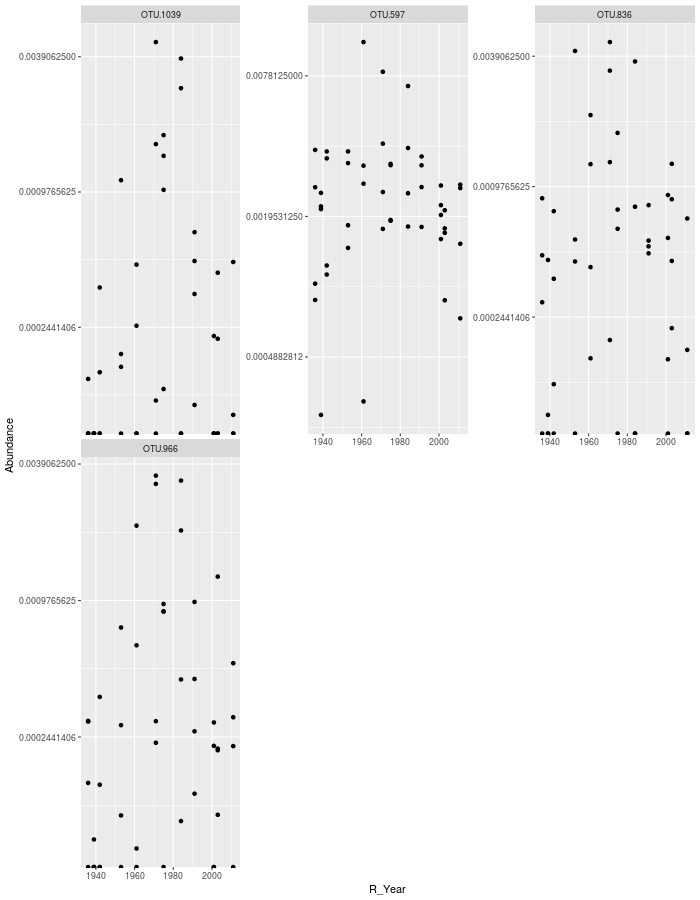

In [65]:
%%R -w 700 -h 900
require(scales)
p = ggplot(ToPlot, aes(x = R_Year, y = Abundance))+
       geom_point()+
     
       facet_wrap(~OTU, scales = "free_y", ncol = 3)+
        scale_y_continuous(trans=log2_trans())
p

In [60]:
%%R
ToPlot %>%
    select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7) %>%
    unique %>% print

PolyTaxa = ToPlot %>% .$OTU %>% unique

         OTU            Rank2                 Rank3             Rank4
60   OTU.597 __Proteobacteria __Gammaproteobacteria __Xanthomonadales
25  OTU.1039    __Chloroflexi        __Anaerolineae  __Anaerolineales
126  OTU.836    __Chloroflexi        __Anaerolineae  __Anaerolineales
147  OTU.966    __Chloroflexi        __Anaerolineae  __Anaerolineales
                 Rank5        Rank6                  Rank7
60  __Xanthomonadaceae __uncultured __uncultured_bacterium
25   __Anaerolineaceae __uncultured __uncultured_bacterium
126  __Anaerolineaceae __uncultured __uncultured_bacterium
147  __Anaerolineaceae __uncultured __uncultured_bacterium


In [61]:
%%R
mat = ToPlot %>%
    group_by(OTU, Rank2, Rank5, Rank6, Plant, R_Year) %>%
    summarize(mAbund = mean(Abundance)) %>%
    as.data.frame() %>%
       mutate(Taxa = paste(OTU, ":_", Rank5, "_", Rank6, sep = "")) %>%
    select(Taxa, R_Year, mAbund) %>%
    spread(R_Year,mAbund) 

rownames(mat) = mat$Taxa
mat = mat[,-1]
head(mat)
mat = data.matrix(mat, rownames.force = TRUE)
mat

                                          1936  1939  1942 1953  1961  1971
OTU.1039:___Anaerolineaceae___uncultured  0.25  0.00  1.00  1.5  1.00  7.00
OTU.597:___Xanthomonadaceae___uncultured 10.75 10.25 22.50 14.0 22.50 26.75
OTU.836:___Anaerolineaceae___uncultured   2.25  0.75  2.00  5.5  5.75 12.75
OTU.966:___Anaerolineaceae___uncultured   1.00  0.25  0.75  1.5  3.75  9.50
                                          1975  1984  1991  2001 2003  2011
OTU.1039:___Anaerolineaceae___uncultured  8.50  8.25  3.50  0.50 0.75  0.75
OTU.597:___Xanthomonadaceae___uncultured 20.50 21.75 25.25 16.25 8.00 11.25
OTU.836:___Anaerolineaceae___uncultured   5.75  8.75  5.25  3.00 3.00  2.00
OTU.966:___Anaerolineaceae___uncultured   5.25  6.75  3.50  0.75 1.50  1.75


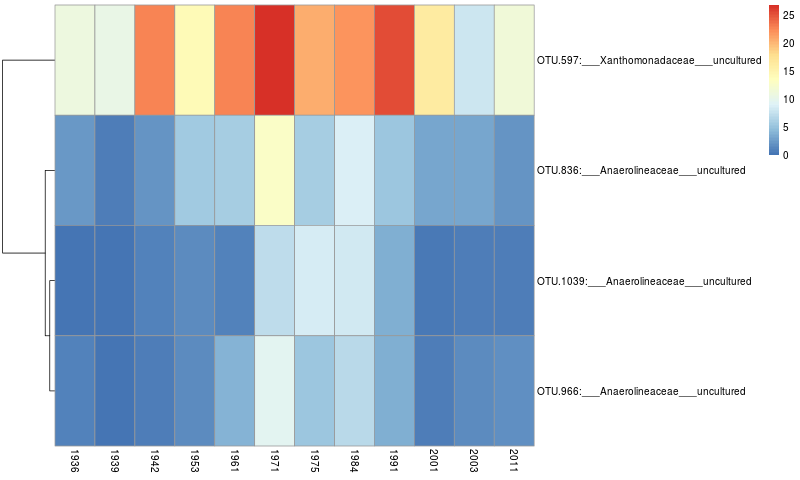

In [62]:
%%R -w 800
pheatmap::pheatmap(mat,
         cluster_col=FALSE)

# l2fc at T3

In [176]:
%%R
physeq.plant.t3 = subset_samples(physeq.plant, TimePoint == "T3")
sample_data(physeq.plant.t3)$Plant = relevel(sample_data(physeq.plant.t3)$Plant, "330" )
sample_data(physeq.plant.t3)$Fert = as.factor(sample_data(physeq.plant.t3)$Fert)
sample_data(physeq.plant.t3)$Rep = as.factor(sample_data(physeq.plant.t3)$Rep)


In [177]:
%%R

diagdds = phyloseq_to_deseq2(physeq.plant.t3, ~ Rep + Fert + Plant)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")



In [178]:
%%R
resultsNames(diagdds)

 [1] "Intercept"    "Rep1"         "Rep2"         "Rep3"         "Rep4"        
 [6] "Fert0"        "Fert85"       "Fert170"      "Plant330"     "Plant3475"   
[11] "Plant34M95"   "Plant3517"    "Plant354"     "PlantP1151HR"


In [179]:
%%R
Plants = sample_data(physeq.plant.t3)$Plant %>% levels %>% .[2:6]
Plants

[1] "3475"    "34M95"   "3517"    "354"     "P1151HR"


In [180]:
%%R
#Function for gathering results

get_res = function(diagdds, plant) {
    r = results(diagdds, contrast=c("Plant", plant, "330"), independentFiltering = TRUE, parallel = TRUE)
    #r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    df = as.data.frame(r[, c("baseMean", "log2FoldChange", "lfcSE", "pvalue", "padj")])
    df$OTU = rownames(df)
    df$Plant = plant
    
    return(df)
}

In [181]:
%%R
df_plant = NULL
df_plant = data.frame()
for (i in Plants) {
    plant = i
    DF = get_res(diagdds, plant)
    df_plant = rbind(df_plant, DF)
}
df_plant$TimePoint = "T3"
df_plant.t3 = df_plant

t.df = tax_table(physeq.plant.t3) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

df_plant.t3 = left_join(df_plant.t3, t.df, by = "OTU")

In [182]:
%%R
df_plant.t3 %>% head

    baseMean log2FoldChange     lfcSE    pvalue padj       OTU Plant TimePoint
1  7.0919597      0.3936002 0.2854371 0.1679137    1   OTU.871  3475        T3
2  0.5654074     -0.5269250 0.4234443 0.2133603    1  OTU.9547  3475        T3
3 14.6904237     -0.1372178 0.2024182 0.4978398    1   OTU.523  3475        T3
4  2.9451143      0.2389038 0.3665647 0.5145707    1  OTU.1107  3475        T3
5  1.1655532      0.4116360 0.4292826 0.3376128    1 OTU.11742  3475        T3
6  2.4309638     -0.2579230 0.3700681 0.4858273    1  OTU.1889  3475        T3
     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxoc

## normalized depth at each time point

In [210]:
%%R
df_plant.t1 %>% 
    group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T1") %>% print

df_plant.t2 %>% 
    group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T2") %>% print

df_plant.t3 %>% 
    group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T3") %>% print

[1] "30141.0035102652 normalized reads at T1"
[1] "32543.8985184371 normalized reads at T2"
[1] "33535.0243078956 normalized reads at T3"


In [ ]:
# Join timepoints

In [183]:
%%R
df_all = bind_rows(df_plant.t1, df_plant.t2, df_plant.t3)

In [184]:
%%R -i workDir


write.csv(df_all, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/1939vsYear.csv", row.names = FALSE, sep = ",")

# Graph changes at T2

In [185]:
%%R
df.l2fc = read.csv("/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/1939vsYear.csv", header = TRUE)

In [186]:
%%R
head(df.l2fc)

    baseMean log2FoldChange     lfcSE    pvalue padj       OTU Plant TimePoint
1  8.7507877    0.142186210 0.2720088 0.6011645    1   OTU.871   354        T1
2  0.3159718   -0.050914616 0.2646183 0.8474228    1  OTU.9547   354        T1
3 15.8508860    0.005701919 0.2331705 0.9804906    1   OTU.523   354        T1
4  2.2112584   -0.356657463 0.3738225 0.3400420    1  OTU.1107   354        T1
5  1.0661659   -0.033434869 0.4072093 0.9345614    1 OTU.11742   354        T1
6  3.2391696   -0.402978411 0.3715884 0.2781541    1  OTU.1889   354        T1
     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxoc

In [187]:
%%R
YR = sample_data(physeq.Full) %>%
    filter(SeedTreatment != "Untreated" & Plant != "Bare") %>%
    as.data.frame() %>%
    select(Plant, R_Year) %>%
    unique %>% 
    filter(Plant!= "322")

YR


     Plant R_Year
1  P1151HR   2011
2    34M95   2001
3      330   1939
4      354   1953
5     3517   1971
6     3475   1984
7     3541   1975
8     3618   1961
9     3394   1991
10   34N42   2003
11     339   1942


In [188]:
%%R
DF = df.l2fc %>% filter(TimePoint == "T2")  %>% as.data.frame()
DF = left_join(DF, YR, by = "Plant")
DF =  mutate(DF, Plant = reorder(Plant,R_Year))
levels(DF$Plant)

 [1] "330"     "339"     "354"     "3618"    "3517"    "3541"    "3475"   
 [8] "3394"    "34M95"   "34N42"   "P1151HR"


In [189]:
%%R
DF$R_Year %>% unique

 [1] 1939 1942 1991 1984 2001 2003 1971 1953 1975 1961 2011


In [190]:
%%R
# Identify top 9 phyla to graph
Phy_toKeep = physeq.plant %>% 
    psmelt() %>%
    group_by(Rank2) %>%
    summarize(Phy_Abund = sum(Abundance)) %>%
    arrange(desc(Phy_Abund)) %>%
    as.data.frame() %>%
    .[1:9,] %>%
    .$Rank2 

In [191]:
%%R
Phy_toKeep

[1] __Actinobacteria   __Proteobacteria   __Acidobacteria    __Chloroflexi     
[5] __Planctomycetes   __Verrucomicrobia  __Bacteroidetes    __Gemmatimonadetes
[9] __Firmicutes      
29 Levels: __Acidobacteria __Actinobacteria ... __WCHB1-60


In [192]:
%%R
# Identify phyla to remove from figure by low base mean and low l2f
# Phy_toKeep = DF %>% group_by(Rank2) %>%
#     summarize(Filter = max(baseMean < 20) & max(abs(log2FoldChange)) < 1 ) %>%
#     filter(Filter == FALSE) %>%
#     .[,"Rank2"] %>% 
#     as.list()


#

DF.p = filter(DF, Rank2 %in% Phy_toKeep & !is.na(R_Year))
DF.p$Rank2 = droplevels(DF.p$Rank2)
#DF.p$R_Year = droplevels(DF.p$R_Year)

In [193]:
%%R
head(DF.p)

    baseMean log2FoldChange     lfcSE     pvalue padj       OTU Plant TimePoint
1  6.7818683    -0.89676535 0.5437824 0.09912196    1   OTU.871   330        T2
2  0.5462976    -0.38256122 0.4414269 0.38613558    1  OTU.9547   330        T2
3 15.7235779    -0.08419484 0.3373967 0.80294110    1   OTU.523   330        T2
4  2.9545293     0.35363727 0.6034456 0.55785530    1  OTU.1107   330        T2
5  0.8649499     0.09464643 0.6198999 0.87865050    1 OTU.11742   330        T2
6  1.8121440     0.49468076 0.6291017 0.43167489    1  OTU.1889   330        T2
     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria 

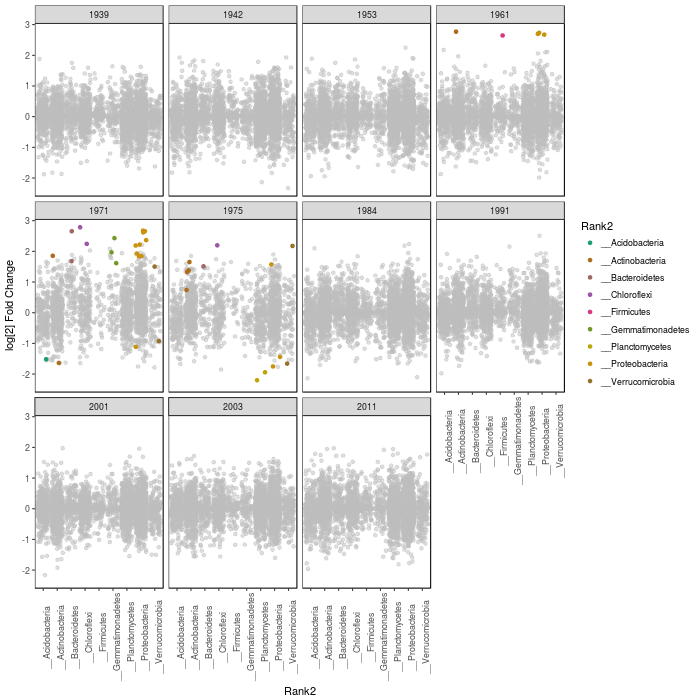

In [194]:
%%R -w 700 -h 700


#df.adj = df_plant.t1[!is.na(df_plant.t1$padj),]

df.sig = DF.p %>% filter(padj < 0.05)
df.ns = DF.p %>% filter(padj >= 0.05)

colourCount = length(unique(DF.p$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(DF.p)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange), color = "Grey", alpha = 0.5, position = "jitter") +
    scale_shape_identity() +
       geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2),position = "jitter") +
               #geom_hline(y_intercept = .4) +
    facet_wrap(~R_Year)+
    theme_pub() +
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))
p

In [195]:
%%R
 df.sig$OTU %>% unique %>% length
#df.sig

[1] 38


## Create metrics and tables by timepoint

In [197]:
%%R

# Explore rhizosphere responders after multiple comparison correction across all comps
sig = df_all %>% filter(padj < 0.05 )

print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", 
            sig$OTU %>% unique %>% length, sep = ""))

sig.t1 = df_all %>% filter(padj < 0.05 & TimePoint == "T1")
print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", sig.t1$OTU %>% unique %>% length, sep = ""))

sig.t2 = df_all %>% filter(padj < 0.05  & TimePoint == "T2")
print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", sig.t2$OTU %>% unique %>% length, sep = ""))

sig.t3 = df_all %>% filter(padj < 0.05 &   TimePoint == "T3")
print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", sig.t3$OTU %>% unique %>% length, sep = ""))


[1] "OTUs differentially abundant from earlierst hybrid sampled: 48"
[1] "OTUs differentially abundant from earlierst hybrid sampled: 6"
[1] "OTUs differentially abundant from earlierst hybrid sampled: 38"
[1] "OTUs differentially abundant from earlierst hybrid sampled: 4"


In [198]:
%%R
sig.t1 

   baseMean log2FoldChange     lfcSE       pvalue        padj       OTU Plant
1  7.665748      -1.698689 0.3993900 2.107304e-05 0.024764686  OTU.3521  3517
2 13.174639      -1.642173 0.3937016 3.031173e-05 0.024764686 OTU.11534  3517
3  9.123596      -1.644914 0.4071804 5.350445e-05 0.032784852  OTU.4313  3517
4  6.898065       1.491062 0.3472081 1.751406e-05 0.024764686   OTU.808  3517
5  3.337030      -1.662755 0.3549319 2.803505e-06 0.006372368   OTU.948 34M95
6 12.065722      -1.557657 0.3803000 4.205950e-05 0.047800621   OTU.399 34M95
  TimePoint    Rank1            Rank2                 Rank3
1        T1 Bacteria __Proteobacteria  __Betaproteobacteria
2        T1 Bacteria __Proteobacteria __Gammaproteobacteria
3        T1 Bacteria __Proteobacteria __Gammaproteobacteria
4        T1 Bacteria __Actinobacteria __Propionibacteriales
5        T1 Bacteria __Proteobacteria __Alphaproteobacteria
6        T1 Bacteria __Proteobacteria  __Betaproteobacteria
                   Rank4          

In [199]:
%%R
write.csv(sig.t1, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t1.csv")

In [201]:
%%R
sig.t2 = sig.t2 %>%
    arrange(Rank2,log2FoldChange)

In [202]:
%%R
write.csv(sig.t2, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t2.csv")
write.csv(sig.t3, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_sig_t3.csv")

In [ ]:
## Plot counts of those OTUs differentially abundant at T1

In [167]:
%%R
phy.snorm = readRDS("/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_snorm.rds")
phy.snorm = subset_samples(phy.snorm, SeedTreatment == "Treated"& TimePoint != "T0" )
phy.snorm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4597 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4597 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4597 tips and 4596 internal nodes ]


In [170]:
# %%R
# # prune phyloseq object to just differentially abundant taxa
# ToKeep = sig$OTU 

# phy.dif = prune_taxa(ToKeep, phy.snorm)
# phy.dif

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 25 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 25 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 25 tips and 24 internal nodes ]


In [182]:
%%R
ToKeep = sig.t1$OTU
mdf.t1 = prune_taxa(ToKeep, phy.snorm) %>%
    psmelt()  %>%
    group_by(Plant, R_Year, OTU) %>%
     summarize(mAbund = mean(Abundance),
                  seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.t1)


Source: local data frame [6 x 5]
Groups: Plant, R_Year [2]

   Plant R_Year       OTU       mAbund      seAbund
  <fctr>  <int>     <chr>        <dbl>        <dbl>
1    322   1936 OTU.11534 9.732498e-05 3.897666e-05
2    322   1936  OTU.3521 2.839119e-04 2.434746e-04
3    322   1936  OTU.4313 1.478318e-05 8.806521e-06
4    322   1936   OTU.808 5.910753e-05 3.077966e-05
5    322   1936   OTU.948 1.167182e-04 1.012595e-04
6    330   1939 OTU.11534 5.048774e-04 2.407976e-04


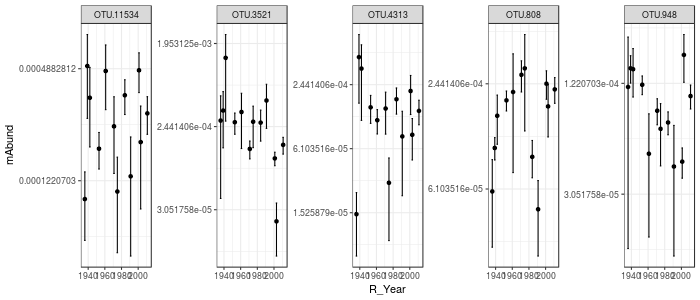

In [185]:
%%R -w 700 -h 300
pT1 = ggplot(mdf.t1, aes(x = R_Year, y = mAbund))+
       geom_point()+
        geom_errorbar(aes(ymin = mAbund - seAbund, ymax = mAbund + seAbund))+
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())

## Plot OTUs differentially abundant at T2

In [156]:
%%R
ToKeep = sig.t2$OTU
mdf.t2 = prune_taxa(ToKeep, phy.snorm) %>%
    psmelt()  %>%
    group_by(Plant, R_Year, OTU) %>%
     summarize(mAbund = mean(Abundance),
                  seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.t2)



Error in prune_taxa(ToKeep, phy.snorm) : object 'phy.snorm' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in prune_taxa(ToKeep, phy.snorm) : object 'phy.snorm' not found

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In write.csv(df_all, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/1939vsYear.csv",  :
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  attempt to set 'sep' ignored

  warnings.warn(x, RRuntimeWarning)


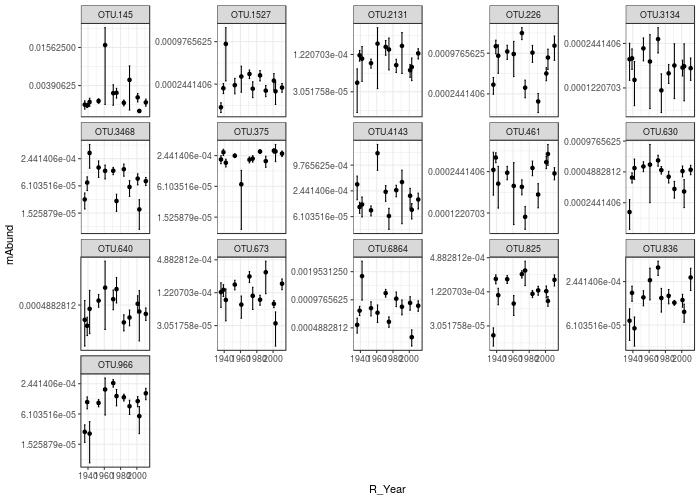

In [189]:
%%R -w 700 -h 500
pT2 = ggplot(mdf.t2, aes(x = R_Year, y = mAbund))+
       geom_point()+
        geom_errorbar(aes(ymin = mAbund - seAbund, ymax = mAbund + seAbund))+
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())
pT2

### Plot OTUs differentially abundant at T3

In [190]:
%%R
ToKeep = sig.t3$OTU
mdf.t3 = prune_taxa(ToKeep, phy.snorm) %>%
    psmelt()  %>%
    group_by(Plant, R_Year, OTU) %>%
     summarize(mAbund = mean(Abundance),
                  seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.t3)


Source: local data frame [6 x 5]
Groups: Plant, R_Year [2]

   Plant R_Year      OTU       mAbund      seAbund
  <fctr>  <int>    <chr>        <dbl>        <dbl>
1    322   1936 OTU.2053 3.368964e-04 1.157632e-04
2    322   1936 OTU.9266 4.509797e-05 3.446595e-05
3    322   1936   OTU.93 2.177639e-03 3.995815e-04
4    322   1936  OTU.950 0.000000e+00 0.000000e+00
5    330   1939 OTU.2053 4.384745e-04 3.736083e-05
6    330   1939 OTU.9266 1.279869e-04 6.994519e-05


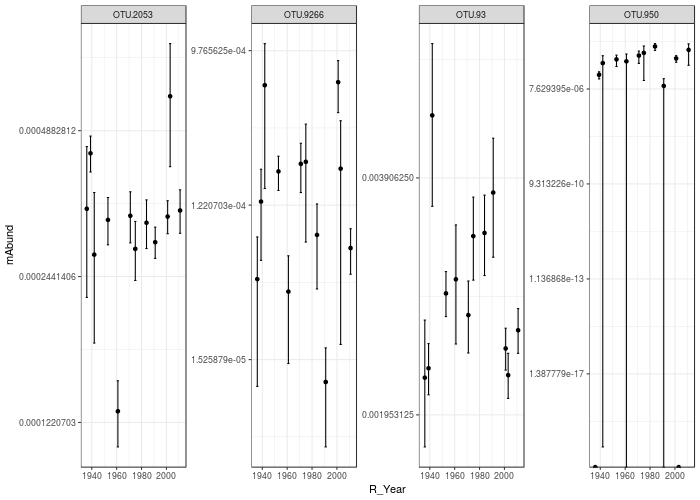

In [192]:
%%R -w 700 -h 500
pT3 = ggplot(mdf.t3, aes(x = R_Year, y = mAbund))+
       geom_point()+
        geom_errorbar(aes(ymin = mAbund - seAbund, ymax = mAbund + seAbund))+
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())
pT3

# Plot top 30 top most abundant otus

In [196]:
%%R
phy.snorm.t2 = subset_samples(phy.snorm, TimePoint == "T2", TRUE)


In [208]:
%%R
T30 = taxa_sums(phy.snorm.t2) %>% sort(decreasing = TRUE)  %>%.[1:30] %>% names()

In [213]:
%%R
ToKeep = T30
mdf.30 = prune_taxa(ToKeep, phy.snorm.t2) %>%
    psmelt() # %>%
  #  group_by(Plant, R_Year, OTU) %>%
  #   summarize(mAbund = mean(Abundance),
   #               seAbund = sd(Abundance)/sqrt(length(Abundance)))
head(mdf.30)

        OTU         Sample  Abundance     X.sampleID TubeID ExtractionPlate
120  OTU.12 ERA-T2_1-4c_85 0.07297040 ERA-T2_1-4c_85    380            ERA1
41   OTU.10 ERA-T2_4-2c_85 0.06575421 ERA-T2_4-2c_85    458            ERA5
196  OTU.14 ERA-T2_1-2c_85 0.05279018 ERA-T2_1-2c_85    364            ERA1
72   OTU.11 ERA-T2_4-4a_85 0.04643745 ERA-T2_4-4a_85    469            ERA5
1269  OTU.5 ERA-T2_1-4c_85 0.04614713 ERA-T2_1-4c_85    380            ERA1
87   OTU.11 ERA-T2_3-3d_85 0.03936835 ERA-T2_3-3d_85    439            ERA4
     PooledDNAPlate Sample.Well.ID PrimerPlate Primer.Number Primer.Well.ID  X
120               A             E6           1            45             E6 NA
41                B            G12           2            95            G12 NA
196               A             D2           1            12             D2 NA
72                B            B12           2            90            B12 NA
1269              A             E6           1            45             

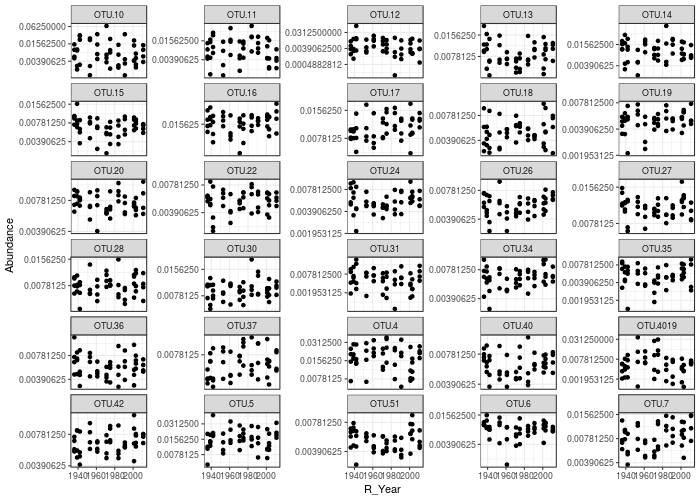

In [214]:
%%R -w 700 -h 500
pT30 = ggplot(mdf.30, aes(x = R_Year, y = Abundance))+
       geom_point()+
     
       facet_wrap(~OTU, scales = "free_y", ncol = 5)+
        scale_y_continuous(trans=log2_trans())
pT30

# Now try plot with the 30 most abundant in any sample

In [216]:
%%R
ToKeep = psmelt(phy.snorm.t2) %>%
  group_by(OTU) %>%
  summarize(max = max(Abundance))%>%
            arrange(desc(max)) %>%
            .$OTU %>%
            .[1:30]
   #               seAbund = sd(Abundance)/sqrt(length(Abundance)))
ToKeep

 [1] "OTU.12"   "OTU.10"   "OTU.145"  "OTU.14"   "OTU.119"  "OTU.11"  
 [7] "OTU.5"    "OTU.4"    "OTU.4019" "OTU.38"   "OTU.16"   "OTU.31"  
[13] "OTU.13"   "OTU.30"   "OTU.17"   "OTU.27"   "OTU.15"   "OTU.6"   
[19] "OTU.28"   "OTU.7"    "OTU.36"   "OTU.69"   "OTU.905"  "OTU.90"  
[25] "OTU.42"   "OTU.20"   "OTU.40"   "OTU.18"   "OTU.37"   "OTU.560" 


In [217]:
%%R
T30 = prune_taxa(ToKeep, phy.snorm.t2) %>%
    psmelt()

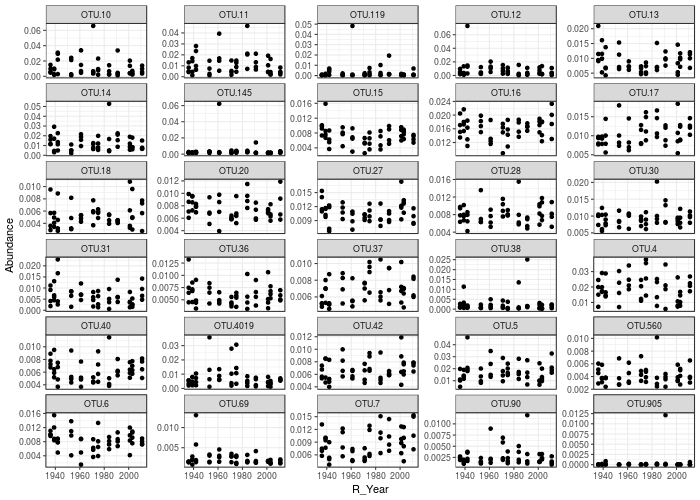

In [224]:
%%R -w 700 -h 500
pT30 = ggplot(T30, aes(x = R_Year, y = Abundance))+
       geom_point()+
     
       facet_wrap(~OTU, scales = "free_y", ncol = 5) #+
       # scale_y_continuous(trans=log2_trans())
pT30